# Model Comparisons
Compute the evaluation metrics and generate the figure for the model comparisons

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd

import initialise
import common

In [2]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
samples_file = os.path.join(common.DATASETS_DIR, 'samples_365days.csv')
model_dir = os.path.join(common.MODELS_DIR, 'comparison_models')
with open(os.path.join(model_dir, 'model_params.json'), 'r') as f:
    model_params = json.load(f)

In [4]:
ensemble_model = common.ANALYSIS_MODEL
ensemble_size = common.ENSEMBLE_SIZE
ensemble_runs = common.ENSEMBLE_RUNS
single_model = common.MODIS_TEMPCNN_MODEL
runs = common.EVALUATION_RUNS
precision = 2
tests = ['Multi-tempCNN:within-site architecture*', 'Multi-tempCNN:out-of-site architecture*',
         'Within-site scenario:out-of-site architecture', 'Out-of-site scenario:within-site architecture',
         'Within-site scenario:Modis-tempCNN', 'Out-of-site scenario:Modis-tempCNN',]
num_tests = len(tests)

# The ensembled results are needed for the Multi-tempCNN comparisons (tests 0 & 1)
ensemble_range = range(2)
# The single models for the Modis-tempCNN comparisons (tests 2 & 3)  
single_range = range(2, 4)

tests

['Multi-tempCNN:within-site architecture*',
 'Multi-tempCNN:out-of-site architecture*',
 'Within-site scenario:out-of-site architecture',
 'Out-of-site scenario:within-site architecture',
 'Within-site scenario:Modis-tempCNN',
 'Out-of-site scenario:Modis-tempCNN']

## Load Model Predictions and Samples

### Multi-tempCNN ensemble models

In [5]:
all_predict = []
all_stats = []
for dir_ in sorted(glob.glob(os.path.join(common.MODELS_DIR, '*site_models')), reverse=True):
    file_name = f"ensemble{ensemble_size}_{ensemble_model}.csv"
    stats_fname = f"ensemble{ensemble_size}_stats.csv"
    all_predict.append(pd.read_csv(os.path.join(dir_, file_name), index_col=0))
    all_stats.append(pd.read_csv(os.path.join(dir_, stats_fname), index_col=(0,1)).loc[ensemble_model].T)
for num in ensemble_range:
    test_name = f'test{num}'
    file_name = f"ensemble{ensemble_size}_{ensemble_model}.csv"
    stats_fname = f"ensemble{ensemble_size}_stats.csv"
    all_predict.append(pd.read_csv(os.path.join(model_dir, test_name, file_name), index_col=0))
    all_stats.append(pd.read_csv(os.path.join(model_dir, test_name, stats_fname), index_col=(0,1)).loc[ensemble_model].T)

### Modis-tempCNN single models

In [6]:
for num in single_range:
    file_name = f"predictions_{single_model}.csv"
    test_name = f'test{num}'
    all_predict.append(pd.read_csv(os.path.join(model_dir, test_name, file_name), index_col=0))
    all_stats.append(pd.read_csv(os.path.join(model_dir, f'test{num}', 'predictions_stats.csv'), index_col=(0,1)).loc[single_model].T)

### Samples 

In [7]:
all_samples = pd.read_csv(samples_file, index_col=0)

## Model Comparison Results

In [8]:
def gen_results(names, predict_stats, predict_counts, precision):
    means = pd.concat([stats_.mean() for stats_ in predict_stats], keys=names).unstack()
    stds = pd.concat([stats_.std() for stats_ in predict_stats], keys=names).unstack()
    counts = pd.Series(predict_counts, index=names)
    df_list = [counts, means.RMSE, stds.RMSE, means.ubRMSE, stds.ubRMSE, means.Bias, stds.Bias, means.R2, stds.R2]
    columns = ['Samples', 'RMSE-mean', 'RMSE-std', 'ubRMSE-mean', 'ubRMSE-std', 'Bias-mean', 'Bias-std', 'R2-mean', 'R2-std']
    return pd.concat(df_list, axis=1).set_axis(columns, axis=1).round(precision)    

### Main Comparisons

In [9]:
counts_list = [pred_.shape[0] for pred_ in all_predict]
gen_results(tests, all_stats, counts_list, precision)

,Samples,RMSE-mean,RMSE-std,ubRMSE-mean,ubRMSE-std,Bias-mean,Bias-std,R2-mean,R2-std
Multi-tempCNN:within-site architecture*,20579,20.87,0.03,20.87,0.03,0.22,0.13,0.70,0.00
Multi-tempCNN:out-of-site architecture*,66946,25.36,0.02,25.36,0.02,0.59,0.15,0.54,0.01
Within-site scenario:out-of-site architecture,20579,24.08,0.03,24.05,0.03,1.22,0.28,0.60,0.01
Out-of-site scenario:within-site architecture,66946,26.68,0.04,26.67,0.04,-0.66,0.09,0.49,0.00
Within-site scenario:Modis-tempCNN,20579,24.40,0.11,24.09,0.08,-3.84,0.40,0.58,0.01
Out-of-site scenario:Modis-tempCNN,66946,27.62,0.07,27.35,0.07,-3.83,0.23,0.45,0.00


### Generate the figure

In [10]:
tests = ['Multi-tempCNN\nwithin-site\narchitecture*', 'Multi-tempCNN\nout-of-site\narchitecture*',
         'Multi-tempCNN\nout-of-site\narchitecture', 'Multi-tempCNN\nwithin-site\narchitecture',
         'Modis-tempCNN', 'Modis-tempCNN',]
scenarios = ['Within-site', 'Out-of-site', 'Within-site', 'Out-of-site', 'Within-site', 'Out-of-site',]
y_labels = ['RMSE (%)', 'Bias (%)', '$R^2$', 'RMSE (%)', 'Bias (%)', '$R^2$',]
fig_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', ]
stats_df = pd.concat(all_stats, keys = pd.MultiIndex.from_arrays([tests, scenarios], names=('Architecture', 'Scenario')))
stats_df = stats_df[['RMSE', 'Bias', 'R2']].stack().reset_index()
stats_df = stats_df.rename(columns={'level_3': 'Statistic', 0: 'Value'})

<Figure size 4308.5x1435 with 0 Axes>

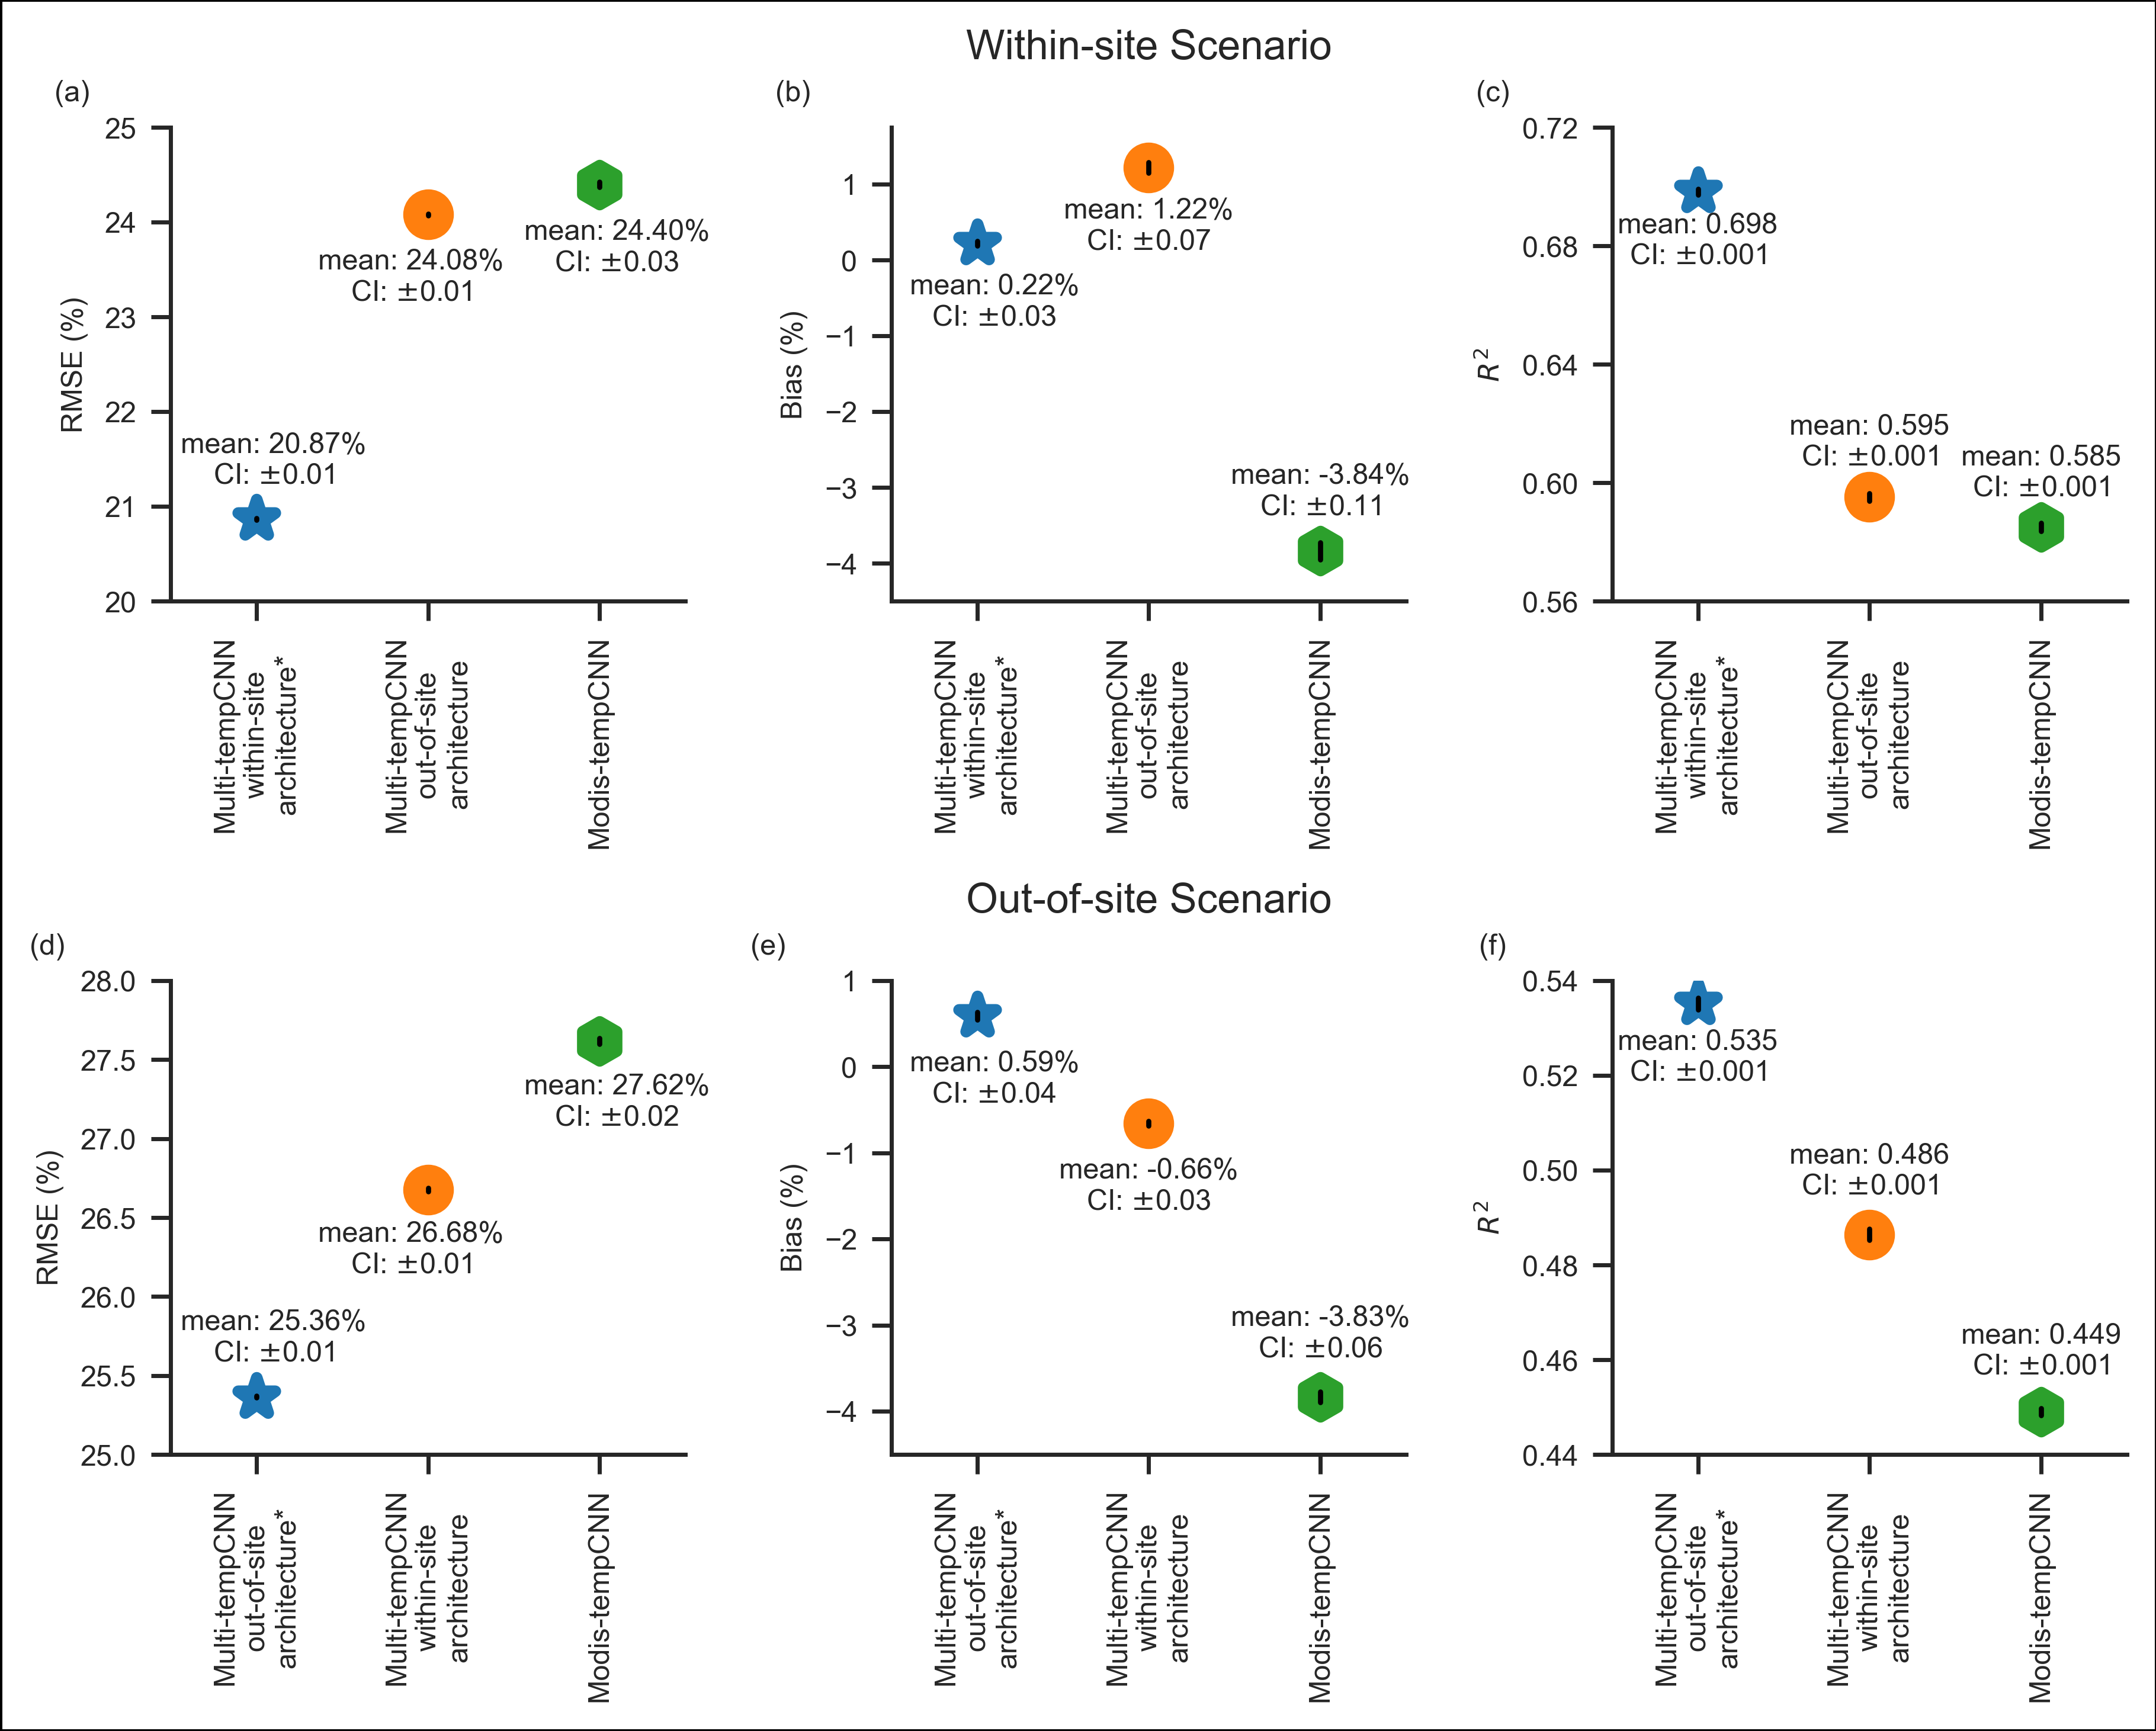

In [11]:
font_size = 7
title_size = 10
plt.rcParams.update({'font.size': font_size})
fig = plt.figure(constrained_layout=False, figsize=(8.617, 2.87), dpi=500, linewidth=1, edgecolor="black")
sns.set_context("paper", rc={"font.size": font_size, "axes.titlesize": title_size, "axes.labelsize": font_size})   
sns.set_style("ticks")
palette = [sns.color_palette()[0], sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[1], sns.color_palette()[2]]
g = sns.catplot(data=stats_df, y='Value', x='Architecture', col='Statistic', row='Scenario', hue='Architecture',
                kind="point", markers=['*', '*', 'o', 'o', 'h'], palette=palette, join=False,  scale=1.75,
                sharey=False, sharex=False)
fig = g.fig
fig.set_size_inches(6.93, 5.0) #(6.930, 4.75)
fig.set_dpi(500)
fig.set_edgecolor('black')
fig.set_linewidth(1)
for n, ax in enumerate(g.axes.ravel()):
    xpos = -24 if n < 2 else -29 if n in [2, 5] else -30
    ax.annotate(fig_labels[n], xy=(0, 1), xytext=(xpos, 5), ha='center', va='bottom', xycoords='axes fraction', textcoords='offset points', fontsize=font_size)
    ax.xaxis.set_tick_params(labelsize=font_size, rotation=90)
    ax.yaxis.set_tick_params(labelsize=font_size)
    ax.set_xlabel(None)
    ax.set_ylabel(y_labels[n])
    if n == 1:
        ax.set_title('Within-site Scenario\n', size=title_size)
    elif n == 4:
        ax.set_title('Out-of-site Scenario\n', size=title_size)
    else:
        ax.set_title(None)
    for line_ in ax.get_lines():
        line_.set_color('black')
        line_.set_lw(1.25)
    annots = {}
    for path in ax.collections:
        points = path.get_offsets()
        point = points[~points.mask]
        if len(point) >= 2:
            annots[point[0]] = {'mean': round(point[1], 4)}
    for line_ in ax.get_lines():
        x_pos = line_.get_data()[0][0]
        ci = line_.get_data()[1]
        if ci[0] == ci[0]:
            annots[x_pos]['ci'] = np.round(ci, 4)
    for x, dict_ in annots.items():
        ha = 'center'
        if n in [2, 5]:
            if n == 2:
                ax.set_ylim([0.56, 0.72])
                ax.set_yticks(np.arange(0.56, 0.73, 0.04))
            else:
                ax.set_ylim([0.44, 0.54])
            x_pos = x
            y_pos = dict_['mean'] * (0.99 if x == 0 else 1.015)
            va = 'top' if x == 0 else 'bottom'
            ci = (dict_['ci'][1] - dict_['ci'][0]) / 2
            text = f"mean: {round(dict_['mean'],3):.3f}\nCI: $\pm${ci:.3f}"
        elif n in [1, 4]:
            if n == 1:
                ax.set_ylim([-4.5, 1.75])
            else:
                ax.set_ylim([-4.5, 1])
            y_off = 0.4
            x_pos = 0.1 if x == 0 else x
            va = 'bottom' if x == 2 else 'top'
            y_off = y_off if x == 2 else -y_off
            y_pos = dict_['mean'] + y_off
            ci = (dict_['ci'][1] - dict_['ci'][0]) / 2
            text = f"mean: {round(dict_['mean'],2):.2f}%\nCI: $\pm${ci:.2f}"
        else:
            if n == 0:
                ax.set_ylim([20, 25])
                y_off = 0.015
            elif n == 3:
                ax.set_ylim([25, 28])
                y_off = 0.0075
            x_pos = 0.9 if x == 1 else (x + 0.1)
            va = 'bottom' if x == 0 else 'top'
            y_off = y_off if x == 0 else -y_off
            y_pos = dict_['mean'] * (1 + y_off)
            ci = (dict_['ci'][1] - dict_['ci'][0]) / 2
            text = f"mean: {round(dict_['mean'],2):.2f}%\nCI: $\pm${ci:.2f}"
        ax.annotate(text, (x_pos, y_pos), va=va, ha=ha, size=font_size)
output_dir = common.FIGURES_DIR
plt.subplots_adjust(wspace=0.4, hspace=0.8)
fig.savefig(os.path.join(output_dir, 'Comparisons.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.2, dpi=500)